# FAST AI ATTEMPT

## SETUP

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *

## EXPLORATION OF DATA

In [2]:
# Load and view the data
train = pd.read_csv('Data/Train.csv')
print(train.shape)
train.head()

(10695, 3)


,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


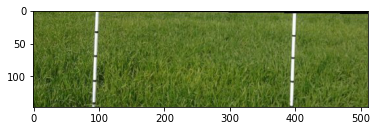

In [3]:
# The images are named based on the UID. The growth_stage is our target colum,
# Loading and viewing an image:
im = PImage.open('Data/images/nwuCTQKz.jpeg')
plt.imshow(im)

In [4]:
train['growth_stage'].unique()

array([4, 1, 6, 3, 7, 2, 5], dtype=int64)

<Figure size 432x288 with 0 Axes>

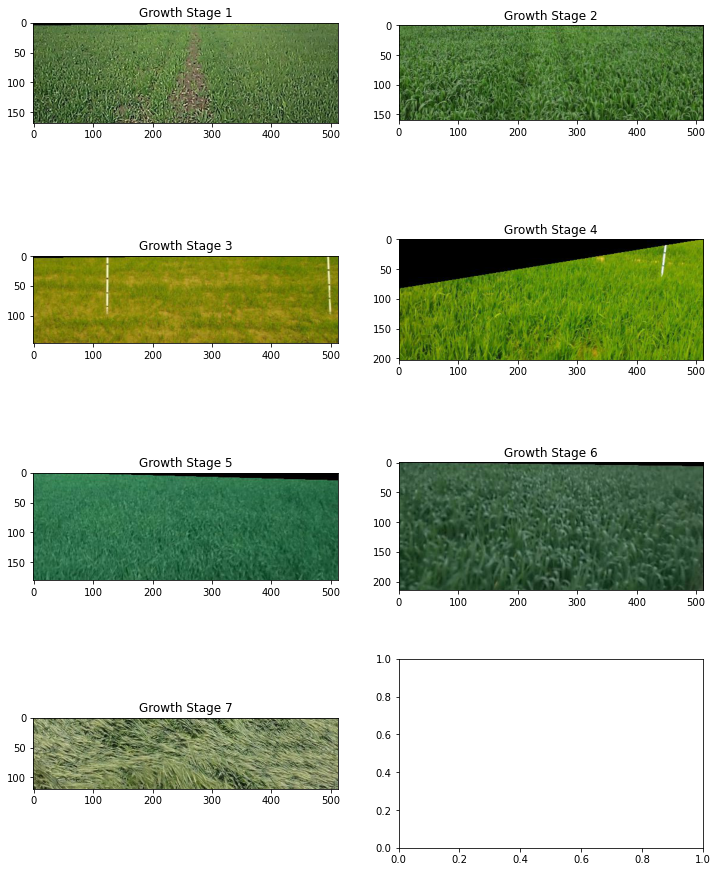

In [5]:
# Plotting an example of each growth stage:
plt.figure()
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

for i, ax in enumerate(axs.flatten()):
  if i+1 in train['growth_stage'].unique(): # If i+1 is a valid growth stage
    im_id = train.loc[(train.growth_stage == i+1)].sample()['UID'].values[0] # Get the ID of an image with the growth stage i+1
    im = PImage.open(f'Data/images/{im_id}.jpeg')
    ax.imshow(im)
    ax.set_title( f'Growth Stage {i+1}')

In [6]:
# HOW MANY IMS FROM EACH GROWTH PHASE DO WE HAVE?
train.growth_stage.value_counts()

1    3057
7    2335
4    1712
2    1389
5    1092
3     689
6     421
Name: growth_stage, dtype: int64

In [7]:
# How many are high-quality?
train.loc[train.label_quality == 2].shape[0]

2856

## MODEL

### PREPARING FOR MODELLING

In [8]:
# Only use the higher quality labels.
train_hq = train.loc[train.label_quality == 2]

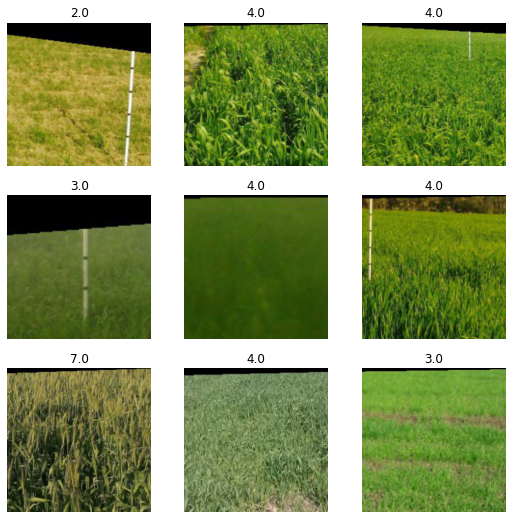

In [16]:
# Create our dataloaders
dls = ImageDataLoaders.from_df(train_hq, path='Data/images/', 
                               suff='.jpeg', 
                               label_col='growth_stage', 
                               item_tfms=Resize(224), 
                               device=torch.device("cuda:0"), 
                               num_workers=0,
                               y_block=RegressionBlock)
dls.show_batch()

### MODEL TRAINING

In [17]:
# doc(cnn_learner.fine_tune) 
learn = cnn_learner(dls, resnet34, metrics=rmse)
learn.fine_tune(15)

epoch,train_loss,valid_loss,_rmse,time
0,17.105429,12.193422,3.491908,02:12


epoch,train_loss,valid_loss,_rmse,time
0,12.215556,10.659925,3.264954,00:37
1,11.120839,7.465395,2.732287,00:37
2,9.345064,7.060593,2.657178,00:40
3,7.141408,2.665440,1.632617,00:40
4,5.376244,1.379643,1.174582,00:40
5,4.276340,1.371490,1.171107,00:39
6,3.459428,1.069905,1.034362,00:40
7,2.875691,0.860222,0.927482,00:39
8,2.460723,0.849942,0.921923,00:40
9,2.105577,0.645220,0.803256,00:39


## SUBMISSION PREPARATION

In [18]:
ss = pd.read_csv('Data/SampleSubmission.csv')
ss.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [21]:
tdl = learn.dls.test_dl(ss)
preds = learn.tta(dl=tdl) 
preds[0].shape # 5 sets of probabilities - one for each class. The high quality labels must not cover a few of the growth phases
preds[0][0] # The predictions for the first test image

tensor([4.6784])

In [22]:
# Update the submission dataframe with our predictions
ss['growth_stage'] = preds[0].numpy()
ss.head()

,UID,growth_stage
0,F3LbWkZq,4.678416
1,6P4wLVzI,3.740609
2,Tn6HIrdS,2.337312
3,EYM5R1TK,4.101164
4,fkcevlA0,4.933737


In [23]:
# Save and submit
ss.to_csv('submission.csv', index=False)

In [24]:
sub2 = pd.read_csv('submission.csv')
sub3 = pd.read_csv('previousSub.csv')
merged = pd.merge(sub2, sub3, on='UID') # Will give two columns of preds - growth_stage_x and growth_stage_y
merged['growth_stage'] = (merged['growth_stage_x'] + merged['growth_stage_y'])/2
merged[['UID', 'growth_stage']].to_csv('sub_ensemble.csv', index=False)